# Variational Auto-Encoder

<img src="https://lilianweng.github.io/lil-log/assets/images/vae-gaussian.png"  width="800" height="400">

##### Importing libraries

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
# fashion_mnist = keras.datasets.fashion_mnist
from matplotlib.markers import MarkerStyle 
from keras import backend as K
from keras.optimizers import Adam
from keras.datasets import mnist 
from keras.layers import Lambda, Input, Dense 
from keras.losses import binary_crossentropy 
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from glob import glob
from PIL import Image
from time import time
from sklearn.model_selection import train_test_split
import os
import imageio
from IPython.display import Image as Img
os.chdir('c:/users/nicolas/documents/data/faces')

Using TensorFlow backend.


##### Function to sort images

In [2]:
def sorted_alphanumeric(data):
    convert = lambda text: int(text) if text.isdigit() else text.lower()
    alphanum_key = lambda key: [ convert(c) for c in re.split('([0-9]+)', key) ]
    return sorted(data, key=alphanum_key)

##### Loading all file names

In [3]:
files = sorted_alphanumeric(glob(r'C:\Users\Nicolas\Documents\Data\faces\combined/*.jpg'))

In [4]:
files[:5]

['C:\\Users\\Nicolas\\Documents\\Data\\faces\\combined\\1_0_0_20161219140623097.jpg.chip.jpg',
 'C:\\Users\\Nicolas\\Documents\\Data\\faces\\combined\\1_0_0_20161219140627985.jpg.chip.jpg',
 'C:\\Users\\Nicolas\\Documents\\Data\\faces\\combined\\1_0_0_20161219140642920.jpg.chip.jpg',
 'C:\\Users\\Nicolas\\Documents\\Data\\faces\\combined\\1_0_0_20161219154018476.jpg.chip.jpg',
 'C:\\Users\\Nicolas\\Documents\\Data\\faces\\combined\\1_0_0_20161219154556757.jpg.chip.jpg']

##### Keeping all correctly formatted labels

In [5]:
np.unique([i[-34] for i in files], return_counts=True)

(array(['0', '1', '9', '_'], dtype='<U1'),
 array([12387, 11316,     1,     5], dtype=int64))

##### Keeping only men/women (not both)

In [6]:
# faces = [i for i in files if (i[-34] == '1') and len(i[-37:-35].strip('\\').strip('d'))  == 2 ] # or in ('0', ''1'')

In [7]:
# y = [i[-34] for i in files if (i[-34] == '1') and len(i[-37:-35].strip('\\').strip('d')) > 1 ]

In [8]:
def load_women():
    faces = pd.read_csv('800_women.csv', header=None).values
    faces = faces.ravel().tolist()
    return faces
faces = load_women()
y = np.repeat(1, len(faces))

In [9]:
assert len(y) == len(faces), 'The X and Y are not of the same length!'

#### Getting shape info, making cropping function

In [10]:
# nrow, ncol, nchan = 200, 200, 3
nrow, ncol, nchan = 60, 60, 3

In [11]:
dim = 60

In [12]:
def crop(img):
    if img.shape[0]<img.shape[1]:
        x = img.shape[0]
        y = img.shape[1]
        crop_img = img[: , int(y/2-x/2):int(y/2+x/2)]
    else:
        x = img.shape[1]
        y = img.shape[0]
        crop_img = img[int(y/2-x/2):int(y/2+x/2) , :]

    return crop_img

##### Loading and cropping images

In [13]:
start = time()
x = []
num_to_load = len(faces)
for ix, file in enumerate(faces[:num_to_load]): 
    image = plt.imread(file, 'jpg')
    image = Image.fromarray(image).resize((dim, dim)).convert('L')
    image = crop(np.array(image))
    x.append(image)
print(f'{int(time() - start)} seconds')
# y = y[:num_to_load]

0 seconds


##### Turning the pictures into arrays

In [14]:
x = np.array(x, dtype=np.float32)
y = np.array(y, dtype=np.float32)

In [15]:
yy, xx = y.nbytes, x.nbytes

In [16]:
print(f'The size of X is {xx:,} bytes and the size of Y is {yy:,} bytes.')

The size of X is 11,520,000 bytes and the size of Y is 3,200 bytes.


In [17]:
print(x.shape)

(800, 60, 60)


In [18]:
files, faces = None, None

##### Cross-validation

In [19]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=2e-1)
x, y = None, None

In [20]:
trainsize, testsize = x_train.shape[0], x_test.shape[0]
print(f'The size of the training set is {trainsize:,} and the '\
     f'size of the test set is {testsize:,}.')

The size of the training set is 640 and the size of the test set is 160.


##### Scaling, casting the arrays

In [21]:
image_size = x_train.shape[1] * x_train.shape[1] 
x_train = np.reshape(x_train, [-1, image_size]) 
x_test = np.reshape(x_test, [-1, image_size]) 
x_train = x_train.astype('float32') / 255 
x_test = x_test.astype('float32') / 255
print('Done.')

Done.


##### Building the VAE

In [22]:
def build_vae(intermediate_dim=512, latent_dim=2):    
    """    
    Build VAE    
    :param intermediate_dim: size of hidden layers of the encoder/decoder    
    :param latent_dim: latent space size    
    :returns tuple: the encoder, the decoder, and the full vae    
    """
    
    # encoder first    
    
    inputs = Input(shape=(image_size,), name='encoder_input')    
    x = Dense(intermediate_dim, activation='relu')(inputs)
    
    # latent mean and variance    
    z_mean = Dense(latent_dim, name='z_mean')(x)    
    z_log_var = Dense(latent_dim, name='z_log_var')(x)
    
    # reparameterization trick for random sampling    
    # Note the use of the Lambda layer    
    # At runtime, it will call the sampling function    
    
    z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])
                                                                
    # full encoder encoder model    
                                                                
    encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')    
    encoder.summary()
    
    # decoder    
                                                                
    latent_inputs = Input(shape=(latent_dim,), name='z_sampling')    
    x = Dense(intermediate_dim, activation='relu')(latent_inputs)    
    outputs = Dense(image_size, activation='sigmoid')(x)
    
    # full decoder model  

    decoder = Model(latent_inputs, outputs, name='decoder')    
    decoder.summary()

    # VAE model    

    outputs = decoder(encoder(inputs)[2])    
    vae = Model(inputs, outputs, name='vae')

    # Loss function    
    # we start with the reconstruction loss    

    reconstruction_loss = binary_crossentropy(inputs, outputs) * image_size

    # next is the KL divergence

    kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)    
    kl_loss = K.sum(kl_loss, axis=-1)    
    kl_loss *= -0.5
    
    # we combine them in a total loss    
    
    vae_loss = K.mean(reconstruction_loss + kl_loss)    
    vae.add_loss(vae_loss)
    
    return encoder, decoder, vae

##### Making a sampler

In [23]:
def sampling(args: tuple):    
    """    
    Reparameterization trick by sampling z from unit Gaussian    
    :param args: (tensor, tensor) mean and log of variance of q(z|x)    
    :returns tensor: sampled latent vector z    
    """
    
    # unpack the input tuple    
    
    z_mean, z_log_var = args
    
    # mini-batch size    
    
    mb_size = K.shape(z_mean)[0]
    
    # latent space size    
    
    dim = K.int_shape(z_mean)[1]
    
    # random normal vector with mean=0 and std=1.0    
    
    epsilon = K.random_normal(shape=(mb_size, dim))
    
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

##### Plotting the distribution

In [24]:
def plot_latent_distribution(encoder, x_test, y_test, batch_size=128):    
    """    
    Display a 2D plot of the digit classes in the latent space.
    We are interested only in z, so we only need the encoder here.    
    :param encoder: the encoder network    
    :param x_test: test images    
    :param y_test: test labels    
    :param batch_size: size of the mini-batch    
    """    
    
    z_mean, _, _ = encoder.predict(x_test, batch_size=batch_size)
    
    plt.figure(figsize=(6, 6))
    markers = ('o', 'x', '^', '<', '>', '*', 'h', 'H', 'D', 'd', 'P', 'X', '8', 's', 'p')
    
    for i in np.unique(y_test):
        plt.scatter(z_mean[y_test == i, 0], z_mean[y_test == i, 1],
        marker=MarkerStyle(markers[int(i)], fillstyle='none'), edgecolors='black')
    
    plt.xlabel("z[0]")    
    plt.ylabel("z[1]")    
    plt.show()

##### Plotting the generated images

In [25]:
def plot_generated_images(decoder):    
    """    
    Display a 2D plot of the generated images.    
    We only need the decoder, because we'll manually sample the distribution z    
    :param decoder: the decoder network    
    """
    
    # display a nxn 2D manifold of digits    
    
    n = 4 # used to be 15    
    digit_size = nrow # used to be 28
    figure = np.zeros((digit_size * n, digit_size * n))    
    
    # linearly spaced coordinates corresponding to the 2D plot    
    # of digit classes in the latent space    
    
    low = -1
    high = 1
    
    grid_x = np.linspace(low, high, n)    
    grid_y = np.linspace(low, high, n)[::-1]
    
    # start sampling z1 and z2 in the ranges grid_x and grid_y    
    
    for i, yi in enumerate(grid_y):        
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])            
            x_decoded = decoder.predict(z_sample)            
            digit = x_decoded[0].reshape(digit_size, digit_size)             
            slice_i = slice(i * digit_size, (i + 1) * digit_size)            
            slice_j = slice(j * digit_size, (j + 1) * digit_size)            
            figure[slice_i, slice_j] = digit
            
     # plot the results    
    
    plt.figure(figsize=(6, 5)) # was 6, 5    
    start_range = digit_size // 2    
    end_range = n * digit_size + start_range + 1    
    pixel_range = np.arange(start_range, end_range, digit_size)    
    sample_range_x = np.round(grid_x, 1)    
    sample_range_y = np.round(grid_y, 1)    
    plt.xticks(pixel_range, sample_range_x)    
    plt.yticks(pixel_range, sample_range_y)    
    plt.xlabel("z[0]")    
    plt.ylabel("z[1]")    
    plt.imshow(figure, cmap='Greys_r')    
    plt.show()

##### Callbacks

In [26]:
e_s = EarlyStopping(monitor='val_loss', patience=100)
m_c = ModelCheckpoint('vae_weights.hdf5', save_best_only=True)

##### Run the entire thing

In [28]:
if __name__ == '__main__': 
    encoder, decoder, vae = build_vae()
    vae.compile(optimizer=Adam(lr=0.002)) 
    vae.summary()

    
#     vae.fit(x_train, epochs=500, batch_size=16, # was 
#             validation_data=(x_test, None),
#             callbacks=[e_s, m_c],
#             verbose=1)
    
#     plot_generated_images(decoder)

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 3600)         0                                            
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 512)          1843712     encoder_input[0][0]              
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 2)            1026        dense_1[0][0]                    
__________________________________________________________________________________________________
z_log_var (Dense)               (None, 2)            1026        dense_1[0][0]                    
____________________________________________________________________________________________

C:\Users\Nicolas\Anaconda3\envs\Pytorch Env\lib\site-packages\keras\engine\training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


In [29]:
vae.load_weights('vae_weights.hdf5')

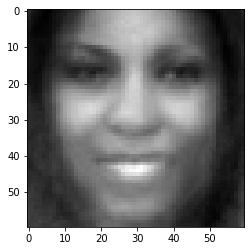

In [30]:
plt.imshow(vae.predict(np.random.uniform(-1, 1, dim*dim).reshape(1, 
                            -1)).reshape(dim, dim), cmap='gray')

In [31]:
min_ = np.linspace(0.1, .7, n)
max_ = np.minimum(min_ + np.random.uniform(0.01, 0.02, n), .7)

In [32]:
def gen_samples(n, minimum, maximum):
        face = []
        for i in range(n):
            face.append(vae.predict(np.random.uniform(minimum, maximum, dim*dim).reshape(1, -1)).reshape(dim, dim))
        return face

In [33]:
if not os.path.isdir('vae_800_women'):
    os.mkdir('vae_800_women')

In [34]:
# png_dir = 'vae_800_women'
# images = []
# for file_name in sorted_alphanumeric(os.listdir(png_dir))[:-20]:
#     if file_name.endswith('.jpg'):
#         file_path = os.path.join(png_dir, file_name)
#         images.append(imageio.imread(file_path))
# images.extend(images[::-1])     

In [37]:
n = 25_000
for i in range(1, n + 1):
    pic = np.mean(gen_samples(n=50, minimum=np.random.uniform(0, 1), 
                              maximum=np.random.uniform(0, 1)), axis=0)*255
    filename = 'vae_800_women/{}.jpg'.format(str(i))
    im = Image.fromarray(pic.astype(np.uint8))
    im.save(filename)
    if (i+1) % 1_000 == 0:
        print(i+1, ' completed.')
print('Done.')

1000  completed.
2000  completed.
3000  completed.
4000  completed.
5000  completed.
6000  completed.
7000  completed.
8000  completed.
9000  completed.
10000  completed.
11000  completed.
12000  completed.
13000  completed.
14000  completed.
15000  completed.
16000  completed.
17000  completed.
18000  completed.
19000  completed.
20000  completed.
21000  completed.
22000  completed.
23000  completed.
24000  completed.
25000  completed.
Done.


In [ ]:
# imageio.mimsave('c:/users/nicolas/desktop/sickgif.gif', images, fps=60)

In [ ]:
Img(filename='c:/users/nicolas/desktop/sickgif.gif')

In [ ]:
plot_generated_images(decoder)

In [ ]:
plot_generated_images(decoder)

In [ ]:
plt.savefig('c:/users/nicolas/desktop.genfaces.jpg')